<a href="https://colab.research.google.com/github/kratiagrawal100/SMAI_Team_30/blob/main/ASL_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# !unzip "/content/drive/MyDrive/SMAI_Project/Sign-Language-Digits-Dataset-master.zip"
!unzip "/content/drive/MyDrive/SMAI project/Sign-Language-Digits-Dataset-master.zip"

In [ ]:
import cv2
import os

def load_images_from_folder(abspath,folder):
    images = []
    labels=[]
    # print(os.path.join(abspath,folder))
    for filename in os.listdir(os.path.join(abspath,folder)):
        # print(os.path.join(abspath,folder,filename))
        img = cv2.imread(os.path.join(abspath,folder,filename))
        if img is not None:
            # print("here")
            # print(img.Resize(28,28))
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(100,100))
            images.append(img)
            labels.append(folder)
    return images,labels
images = []
labels=[]
for i in range(10):
  img,lbls=load_images_from_folder("/content/Sign-Language-Digits-Dataset-master/Dataset",str(i))
  images.extend(img)
  labels.extend(lbls)

In [ ]:
print(len(images),len(labels))

2062 2062


(100, 100, 3)


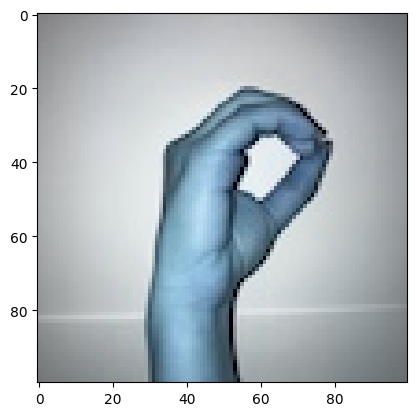

In [ ]:
import matplotlib.pyplot as plt
print(images[200].shape)
plt.imshow(images[0])

In [ ]:
import pickle as pkl
import tarfile
import tarfile
from urllib.request import urlretrieve
import os


import numpy as np
import skimage
import skimage.io
import skimage.transform
import torchvision


def _compose_image(digit, background):
    """Difference-blend a digit and a random patch from a background image."""
    w, h, _ = background.shape
    dw, dh, _ = digit.shape
    # print(w,dw)
    x = np.random.randint(0, w - dw)
    y = np.random.randint(0, h - dh)

    bg = background[x:x+dw, y:y+dh]
    return np.abs(digit-(bg/2)+20).astype(np.uint8)


def _mnist_to_img(x):
    """Binarize MNIST digit and convert to RGB."""
    # x = (x > 0).astype(np.float32)
    # d = x.reshape([100, 100,1 ]) * 255
    # return np.concatenate([d, d, d], 2)
    return x


def _create_mnistm(X, rand, background_data):
    """
    Give an array of MNIST digits, blend random background patches to
    build the MNIST-M dataset as described in
    http://jmlr.org/papers/volume17/15-239/15-239.pdf
    """
    X_ = np.zeros([X.shape[0], 100, 100, 3], np.uint8)
    for i in range(X.shape[0]):

        if i % 10000 == 0:
            print('Processing example', i)

        bg_img = rand.choice(background_data)

        d = _mnist_to_img(X[i])
        d = _compose_image(d, bg_img)
        X_[i] = d

    return X_


def create_mnistm():
  if os.path.exists('ASL_data.pkl'):
    return

  if not os.path.exists("BSR_bsds500.tgz"):
    urlretrieve("http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz", "BSR_bsds500.tgz")
  print('Creating MNIST-M... That may takes a minute')
  BST_PATH = 'BSR_bsds500.tgz'

  rand = np.random.RandomState(42)

  f = tarfile.open(BST_PATH)
  train_files = []
  for name in f.getnames():
      if name.startswith('BSR/BSDS500/data/images/train/'):
          train_files.append(name)

  print('Loading BSR training images')
  background_data = []
  for name in train_files:
      try:
          fp = f.extractfile(name)
          bg_img = skimage.io.imread(fp)
          background_data.append(bg_img)
      except:
          continue

  # mnist_train = torchvision.datasets.MNIST('.', train=True, download=True)
  # mnist_test = torchvision.datasets.MNIST('.', train=False, download=True)

  print('Building train set...')
  train = _create_mnistm(np.array(images), rand, background_data)
  print('Building test set...')
  test = _create_mnistm(np.array(images), rand, background_data)

  # Save dataset as pickle
  with open('ASL.pkl', 'wb+') as f:
      pkl.dump({ 'x_train': train, 'x_test': test, "y_train": np.array(labels), "y_test":np.array(labels)}, f, pkl.HIGHEST_PROTOCOL)

  print("Done!")


In [ ]:
create_mnistm()

Creating MNIST-M... That may takes a minute
Loading BSR training images
Building train set...
Processing example 0


<ipython-input-7-64bf313ab6cc>:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bg_img = rand.choice(background_data)


Building test set...
Processing example 0
Done!


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images,labels, test_size=0.25, random_state=42)

In [ ]:
import torch
class ASL(torch.utils.data.Dataset):
  def __init__(self, x, y):
    self.x, self.y = x, y
    # self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    # x = self.transform(x)

    return x, y
asl_train = ASL(images,labels)
asl_train,asl_test=torch.utils.data.random_split(asl_train, [1562, 500])
# asl_train, asl_test, y_train, y_test = train_test_split(images,labels, test_size=0.25, random_state=42)

source_train_loader = DataLoader(asl_train, batch_size=32)
source_test_loader = DataLoader(asl_test, batch_size=32)

In [ ]:
with open('ASL.pkl', 'rb') as f:
  asl_m = pickle.load(f)
class ASLM(torch.utils.data.Dataset):
  def __init__(self, x, y):
    self.x, self.y = x, y
    # self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    # x = self.transform(x)

    return x, y

aslm_train = ASLM(asl_m["x_train"],asl_m["y_train"])
aslm_train,aslm_test=torch.utils.data.random_split(aslm_train, [1562, 500])

target_train_loader = DataLoader(aslm_train, batch_size=32)
target_test_loader = DataLoader(aslm_test, batch_size=32)

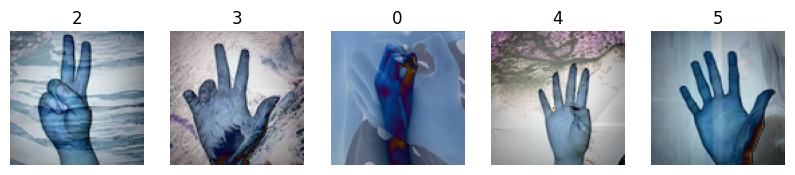

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = aslm_train[i]
  img = (x)
  plt.imshow(img)
  # plt.imshow(images[i])
  plt.title(y)

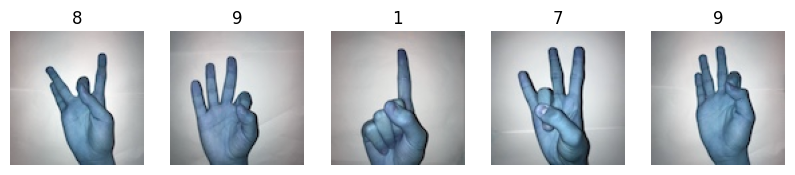

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x,y= asl_train[i]
  plt.imshow(x)
  # plt.imshow(images[i])
  plt.title(y)